# Spaceshift Titanic

## LogBook

In [1]:
# 10/07/22 --> Notebook Creation


# Author: Andres Montes de Oca
# LinkedIn: https://www.linkedin.com/in/jamontesdeoca/
# GitHub: N/A

## Load Data and Quick Look

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='white', context='notebook', palette='RdYlGn')

train = pd.read_csv('Data/train.csv')
data = train
test = pd.read_csv('Data/test.csv')


# y = train['Transported'] # Not now

In [3]:
print(data.info())
display(data.head())
# display(data.describe())
# display(data.describe(include='object'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# print(test.info())
# display(test.head())

## Individual Features Check

### Transported (Target)

Transported in Train: 0.5036236051995858
Transported in Test: N/A


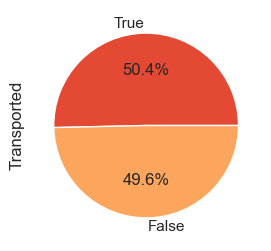

In [5]:
print('Transported in Train:', data['Transported'].mean())
print('Transported in Test: N/A', )

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
data['Transported'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.show()

# We will use it later
mask_transported = data['Transported']==True

# Transported is well balanced

### PassengerId

In [6]:
print('Nulls:', data.PassengerId.isnull().sum(), '\n')
print(data.PassengerId.head())


# We will have to split the GroupId form this Feature, there are no nulls

Nulls: 0 

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object


#### Split (PassangerId)

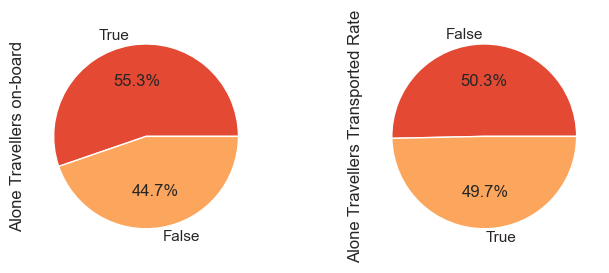

In [7]:
# GroupId Feature Generation
data['GroupId'] = data['PassengerId'].str.split('_', expand=True)[0]

# Grouping by GroupId to count each group size
GroupId_size_serie = data.groupby('GroupId').size() # temp GroupId_size Serie
GroupId_size_serie.rename('GroupSize', inplace=True) # necesary for the Join


# IsAlone Feature Generation
# First we add how many passengers are in the group
data = pd.merge(left=data, right=GroupId_size_serie, left_on='GroupId', right_on='GroupId', how='left')

# Then we filter just the lonley travelelrs
data.loc[:, 'IsAlone'] = data['GroupSize']==1 # Or we can leave it as it is, maybe improves the results
# data.rename(columns={'Group_size':'IsAlone'}, inplace=True)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
data['IsAlone'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%', ax=ax[0])
ax[0].set_ylabel('Alone Travellers on-board')

data.loc[mask_transported, 'IsAlone'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%', ax=ax[1])
ax[1].set_ylabel('Alone Travellers Transported Rate')
plt.show()

# There are more Alone Travellers but they have similar Transported Rate as the Population

### HomePlanet

#### Distribution and Correlation with Target Variable

Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64


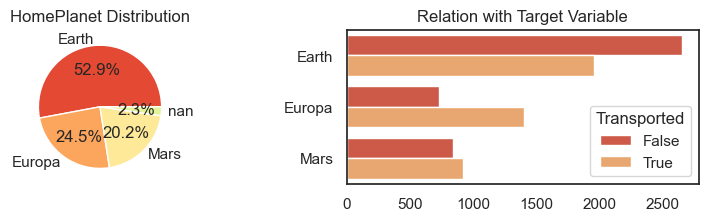

In [8]:
print(data['HomePlanet'].value_counts(dropna=False))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
data['HomePlanet'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%', ax=ax[0])
ax[0].set_ylabel('')
ax[0].set_title('HomePlanet Distribution')
sns.countplot(y=data['HomePlanet'], order=data['HomePlanet'].value_counts().index, ax=ax[1], hue=data['Transported'])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Relation with Target Variable')

plt.show()

# There are 201 nulls
# Most coming from Earth
# Passangers from Europe have more chances to be Transported
# Pending: Reduce annot_size for the PieChart

#### Nulls Check

In [9]:
# Counting and Checking nulls
print('Nulls Count:', data[data.HomePlanet.isnull()].shape[0], '\n')

# Passangers in Groups
display('Passengers in groups', data[data.HomePlanet.isnull() & ~(data.IsAlone)].head(3))
print('In groups with other passengers',data[data.HomePlanet.isnull() & ~(data.IsAlone)].shape[0])

# We can get HomePlanet from GroupId for almost 50% of NA. Lets check if this is a valid approach

Nulls Count: 201 



'Passengers in groups'

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,GroupSize,IsAlone
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True,0064,2,False
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False,0119,2,False
405,0444_02,NaN,False,F/99/P,TRAPPIST-1e,26.0,True,1869.0,0.0,136.0,0.0,0.0,Colal Curte,False,0444,2,False


In groups with other passengers 92


#### FillNA Check (HomePlanet)

In [10]:
# Lets confirm all members of each group member departed from the same HomePlanet

data_grp_groupid_homeplanet = data.groupby(['GroupId', 'HomePlanet']).size().to_frame('Count').reset_index()
display(data_grp_groupid_homeplanet)

# There are no duplicated GroupId, so is all OK
print('Is GroupId unique?:', data_grp_groupid_homeplanet.GroupId.is_unique)

,GroupId,HomePlanet,Count
0,0001,Europa,1
1,0002,Earth,1
2,0003,Europa,2
3,0004,Earth,1
4,0005,Earth,1
...,...,...,...
6102,9275,Europa,3
6103,9276,Europa,1
6104,9278,Earth,1
6105,9279,Earth,1


Is GroupId unique?: True


#### FillNa (HomePlanet)

In [11]:
# Filling Lonley Travelers with the mode
data.loc[data.HomePlanet.isnull() & data.IsAlone, 'HomePlanet'] = data.HomePlanet.mode()[0]

# Filling Passangers in Groups with value from same GroupId
data.loc[:, 'HomePlanet'] = data.sort_values(by=['GroupId', 'HomePlanet'])['HomePlanet'].fillna(method='ffill')
print('New Nulls Count:', data.HomePlanet.isnull().sum())

New Nulls Count: 0


### CryoSleep

#### Distribution and correlation with Target Variable

False    5439
True     3037
NaN       217
Name: CryoSleep, dtype: int64


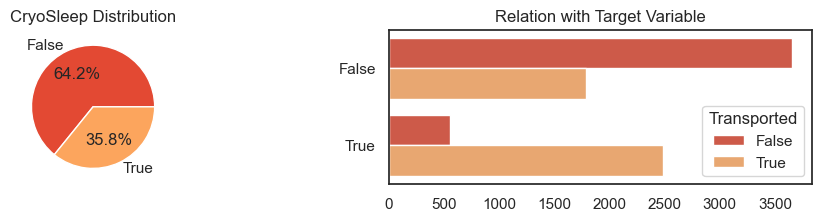

In [12]:
# Transform to Numeric, otherwise piechart doesn't include Nulls
# data.loc[data.CryoSleep==True, 'CryoSleep'] = 1
# data.loc[data.CryoSleep==False, 'CryoSleep'] = 0

print(data['CryoSleep'].value_counts(dropna=False))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
data['CryoSleep'].value_counts().plot(kind='pie', autopct='%.1f%%', ax=ax[0])
ax[0].set_ylabel('')
ax[0].set_title('CryoSleep Distribution')
sns.countplot(y=data['CryoSleep'], hue=data['Transported'], ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Relation with Target Variable')
plt.show()

# There are 217 Nulls
# Just 1/3 are in CryoSleep
# Strong correlation with Target Variable

#### Correlation with VIP

Total VIP Passengers: 199


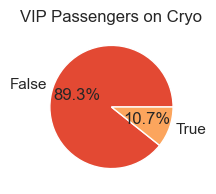

In [13]:
print('Total VIP Passengers:', data[data.VIP==True].shape[0])
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
data[data.VIP==True].CryoSleep.value_counts().plot(kind='pie', autopct='%.1f%%')
ax.set_ylabel('')
ax.set_title('VIP Passengers on Cryo')
# sns.countplot(y=)
plt.show()

# There few VIP Passengers
# Strong correlation, VIP passengers dont want to be put to sleep

#### Correlation with Age

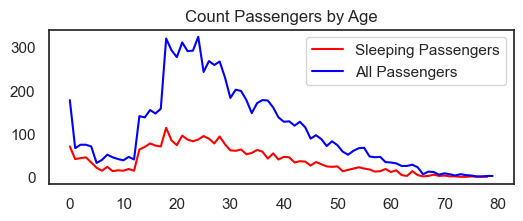

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
data[data.CryoSleep==True].Age.value_counts().sort_index().plot(title='Count Passengers by Age', color='red', label='Sleeping Passengers')
data.Age.value_counts().sort_index().plot(color='blue', label='All Passengers')
plt.legend()
plt.show()

# Most Seniors (+65 years) are put to sleep, but they are few
# Same happens with kids (0 to 12 years)????
# The gap between both gets gradually reduced for adults (18 to 65 years) 

#### Correlation with GroupSize

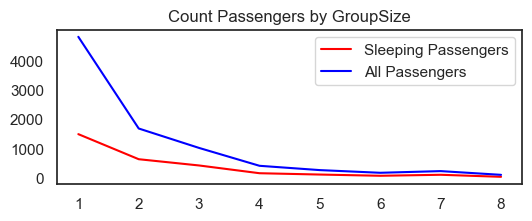

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
data[data.CryoSleep==True].GroupSize.value_counts().sort_index().plot(title='Count Passengers by GroupSize', 
                                                                      color='red', label='Sleeping Passengers')
data.GroupSize.value_counts().sort_index().plot(color='blue', label='All Passengers')
plt.yticks(np.arange(0, 5000, 1000))
plt.legend()
plt.show()

# The bigger the GroupSize, more chances of CryoSleep?

#### FillNa (CryoSleep)

In [16]:
print('Nulls Count Original:', data[data.CryoSleep.isnull()].shape[0], '\n')

# Complete with VIPs (90% Rate)
data.loc[data.CryoSleep.isnull() & data.VIP, 'CryoSleep']=False # 214 to go
print('Nulls Count after VIPs:', data[data.CryoSleep.isnull()].shape[0], '\n')

# Complete for Kids and Seniors (to be tested)
data.loc[data.CryoSleep.isnull() & np.logical_or(data.Age>=65, data.Age<=12), 'CryoSleep'] = True
print('Nulls Count after Age:', data[data.CryoSleep.isnull()].shape[0], '\n')

Nulls Count Original: 217 

Nulls Count after VIPs: 214 

Nulls Count after Age: 189 



### Cabin

In [18]:
print('Nulls:', data['Cabin'].isnull().sum(), '\n')
print(data['Cabin'].head()) # PortSide/StarboardSide: Left/Right


# Split into Deck/Num/Side, 199 nulls

Nulls: 199 

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object


### Destination

In [ ]:
print(data['Destination'].value_counts(dropna=False))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
data['Destination'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%', ax=ax[0])
sns.countplot(y=data['Destination'], order=data['Destination'].value_counts().index, ax=ax[1])
ax[1].set_ylabel('')
plt.show()

# Similar to HomePlanet. Most passengers heading TRAPPIST-1e, 182 Nulls

### Age

In [ ]:
print('Nulls:', data['Age'].isnull().sum())
print("Skewness: %f" % data['Age'].skew(), '\n') # Right
print(data['Age'].describe())

# Plots
fig,ax=plt.subplots(1,1,figsize=(18,4))
sns.histplot(data=data['Age'])
plt.title('Age')
plt.show()

### VIP

In [ ]:
print(data['VIP'].value_counts(dropna=False))

fig,ax=plt.subplots(1,1,figsize=(4,3))
data['VIP'].value_counts(dropna=False).plot(kind='pie', autopct='%.1f%%')
ax.set_ylabel('')
plt.title('VIP')
plt.show()

# Most are standard passengers, few VIPS and few Nulls

### Name

In [ ]:
print('Nulls:', data['Name'].isnull().sum(), '\n')
print(data['Name'].value_counts())

# 200 nulls, couple of name repeted

### RoomService

In [ ]:
print('Nulls:', data['RoomService'].isnull().sum(), '\n')
print(data['RoomService'].describe())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(y=data['RoomService'], showfliers=False)
ax.set_ylabel('')
plt.title('RoomService(w/o Outliers)')
plt.show()

### FoodCourt

In [ ]:
print('Nulls:', data['FoodCourt'].isnull().sum(), '\n')
print(data['FoodCourt'].describe())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(y=data['FoodCourt'], showfliers=False)
ax.set_ylabel('')
plt.title('FoodCourt(w/o Outliers)')
plt.show()

### ShoppingMall

In [ ]:
print('Nulls:', data['ShoppingMall'].isnull().sum(), '\n')
print(data['ShoppingMall'].describe())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(y=data['ShoppingMall'], showfliers=False)
ax.set_ylabel('')
plt.title('ShoppingMall(w/o Outliers)')
plt.show()

### Spa

In [ ]:
print('Nulls:', data['Spa'].isnull().sum(), '\n')
print(data['Spa'].describe())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(y=data['Spa'], showfliers=False)
ax.set_ylabel('')
plt.title('Spa(w/o Outliers)')
plt.show()

### VRDeck

In [ ]:
print('Nulls:', data['VRDeck'].isnull().sum(), '\n')
print(data['VRDeck'].describe())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(y=data['VRDeck'], showfliers=False)
ax.set_ylabel('')
plt.title('Spa(w/o Outliers)')
plt.show()